In [1]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import os
import shutil

parent_dir = os.getcwd()

#### Convert Training Data to DataFrames for the Neural Network

In [2]:
training_path = os.path.join(parent_dir, "training_data")
training_files = glob.glob(training_path + "/*.csv")
data = []
for file in training_files:
    df = pd.read_csv(file, usecols = [i for i in range(1, 42)])
    df = df.drop(['team1','team2','1MIN', '2MIN'], axis=1)
    data.append(df)

training_data = pd.concat(data, axis=0, ignore_index=True)

#### Convert Validation Data to DataFrames for the Neural Network

In [3]:
test_path = os.path.join(parent_dir, "test_data")
test_files = glob.glob(test_path + "/*.csv")
data = []
for file in test_files:
    df = pd.read_csv(file, usecols = [i for i in range(1, 42)])
    df = df.drop(['team1','team2','1MIN', '2MIN'], axis=1)
    data.append(df)

test_data = pd.concat(data, axis=0, ignore_index=True)

#### Split the Features and the Labels 

In [5]:
training_features = training_data.copy()
training_labels = training_features.pop('net')

test_features = test_data.copy()
test_labels = test_features.pop('net')

## Neural Net Construction

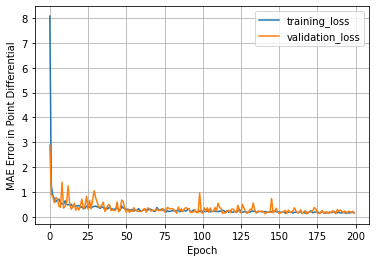

In [11]:
##Normalize Data
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(training_features))

model = tf.keras.Sequential()
model.add(normalizer)
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(loss = 'mean_absolute_error', optimizer='Adam')

history = model.fit(training_features, training_labels, epochs=200, verbose=0, validation_split=0.2)

plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Error in Point Differential')
plt.legend()
plt.grid(True)
plt.show()

## Neural Net Testing

Text(0.5, 1.0, 'Model Predicted vs Actual Point Differentials, where PD = Away Team - Home Team')

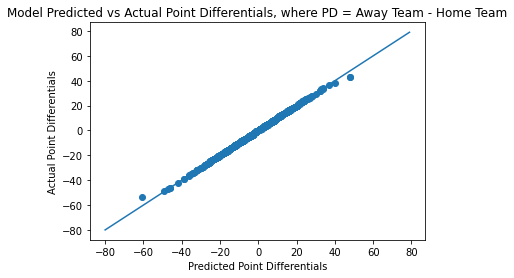

In [15]:
predictions = model.predict(test_features).flatten()
plt.scatter(test_labels, predictions)
x = range(-80, 80)
y = x
plt.plot(x, y)
plt.xlabel('Predicted Point Differentials')
plt.ylabel('Actual Point Differentials')
plt.title('Model Predicted vs Actual Point Differentials, where PD = Away Team - Home Team')